##### Run this cell to set your notebook up (only mandatory if rlss2019-docker image is not used)

In [0]:
!git clone https://github.com/yfletberliac/rlss2019-hands-on.git > /dev/null 2>&1

# Reinforcement Learning - Practical Session 1


## Review

A Markov Decision Process (MDP) is defined as tuple $(S, A, P, r, \gamma)$ where:
* $S$ is the state space
* $A$ is the action space 
* $P$ represents the transition probabilities, $P(s,a,s')$ is the probability of arriving at state $s'$ by taking action $a$ in state $s$
* $r$ is the reward function such that $r(s,a,s')$ is the reward obtained by taking action $a$ in state $s$ and arriving at $s'$
* $\gamma$ is the discount factor

A deterministic policy $\pi$ is a mapping from $S$ to $A$: $\pi(s)$ is the action to be taken at state $s$.

The goal of an agent is to find the policy $\pi$ that maximizes the expected sum of discounted rewards by following $\pi$. The value of $\pi$ is defined as

$$
V_\pi(s) = E\left[ \sum_{t=0}^\infty \gamma^t r(S_t, A_t, S_{t+1}) | S_0 = s \right]
$$

$V_\pi(s)$ and the optimal value function, defined as $V^*(s) = \max_\pi V_\pi(s)$, can be shown to satisfy the Bellman equations:

$$
V_\pi(s) = \sum_{s' \in S}  P(s,\pi(s),s')[r(s,\pi(s),s') + \gamma V_\pi(s')]
$$


$$
V^*(s) = \max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

It is sometimes better to work with Q functions:

$$
Q_\pi(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma  Q_\pi(s', \pi(s')]
$$


$$
Q^*(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma \max_{a'} Q^*(s', a')]
$$

such that $V_\pi(s) = Q_\pi(s, \pi(s))$ and $V^*(s) = \max_a Q^*(s, a)$.


### Using value iteration to compute an optimal policy
If the reward function and the transition probabilities are known (and the state and action spaces are not very large), we can use dynamic programming methods to compute $V^*(s)$. Value iteration is one way to do that.


#####  Value iteration to compute $V^*(s)$
$$
T^* Q(s,a) = \sum_{s'}P(s'|s,a)[ r(s, a, s') + \gamma \max_{a'} Q(s', a')]   \\
$$


* For any $Q_0$, let $Q_n = T^* Q_{n-1}$. 
* We have $\lim_{n\to\infty}Q_n = Q^*$ and $Q^* = T^* Q^*$


##### Finding the optimal policy from $V^\pi(s)$

The optimal policy $\pi^*$ can be computed as

$$
\pi^*(s) \in \arg\max_{a\in A} Q^*(s, a) =  \arg\max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

###  Q-Learning and SARSA 

When the reward function and the transition probabilities are *unknown*, we cannot use dynamic programming to find the optimal value function. Q-Learning and SARSA are stochastic approximation algorithms that allow us to estimate the value function by using only samples from the environment.

#####  Q-learning

The Q-Learning algorithm allows us to estimate the optimal Q function using only trajectories from the MDP obtained by following some exploration policy. 

Q-learning with $\varepsilon$-greedy exploration does the following update at time $t$:

1. In state $s_t$, take action $a_t$  such that $a_t$ is random with probability $\varepsilon$ and $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ with probability $1-\varepsilon$;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Compute $\delta_t = r_t + \gamma \max_a \hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t)$;
4. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}  $


##### SARSA

SARSA is similar to Q-learning, but it is an *on-policy* algorithm: it follows a (stochastic) policy $\pi_Q$ and updates its estimate towards the value of this policy. One possible choice is:

$$
\pi_Q(a|s) = \frac{ \exp(\tau^{-1}Q(s,a))  }{\sum_{a'}\exp(\tau^{-1}Q(s,a')) }
$$
where $\tau$ is a "temperature" parameter: when $\tau$ approaches 0, $\pi_Q(a|s)$ approaches the greedy (deterministic) policy $a \in \arg\max_{a'}Q(s,a')$.

At each time $t$, SARSA keeps an estimate $\hat{Q}_t$ of the true Q function and uses $\pi_{\hat{Q}_t}(a|s)$ to choose the action $a_t$. If $\tau \to 0$ with a proper rate as $t \to \infty$, $\hat{Q}_t$ converges to $Q$ and $\pi_{\hat{Q}_t}(a|s)$ converges to the optimal policy $\pi^*$. 

The SARSA update at time $t$ is done as follows:

1. In state $s_t$, take action $a_t \sim \pi_{\hat{Q}_t}(a|s_t)$ ;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Sample the next action $a_{t+1} \sim \pi_{\hat{Q}_t}(a|s_{t+1})$;
4. Compute $\delta_t = r_t + \gamma \hat{Q}_t(s_{t+1}, a_{t+1}) - \hat{Q}_t(s_t, a_t)$
5. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$

## Goals

Your goal is to implement Value Iteration, Q-Learning and SARSA for the [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) environment.

* In exercise 1, you will implement the Bellman operator $T^*$ and verify its contraction property.
* In exercise 2, you will implement value iteration.
* In exercises 3 and 4, you will implement Q-Learning and SARSA.


In [1]:
import sys
sys.path.insert(0, './rlss2019-hands-on/utils')
# If using the Docker image, replace by:
# sys.path.insert(0, '../utils')

import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
from frozen_lake import FrozenLake
from test_env import ToyEnv1

# FrozenLake environment

(You can use ToyEnv1 to debug your algorithms)

In [445]:
# Creating an instance of FrozenLake
# --- If deterministic=False, transitions are stochastic. Try both cases!
env = FrozenLake(gamma=0.95, deterministic=True, data_path="./rlss2019-hands-on/data") 

# Small environment for debugging
#env = ToyEnv1(gamma=0.95)

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

# Visualizing the environment
try:
    env.render()
except:
    pass # render not available

Set of states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Set of actions: [0, 1, 2, 3]
Number of states:  16
Number of actions:  4
P has shape:  (16, 4, 16)
discount factor:  0.95

initial state:  0
reward at (s=1, a=3,s'=2):  0.0

random policy =  [1 0 0 0 3 0 1 1 0 0 3 0 0 0 1 1]
(s, a, s', r):
0 1 4 0.0
4 3 0 0.0
0 1 4 0.0
4 3 0 0.0

(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 0


# Exercise 1: Bellman operator

1. Write a function that takes an environment and a state-action value function $Q$ as input and returns the Bellman optimality operator applied to $Q$, $T^* Q$ and the greedy policy with respect to $Q$.
3. Let $Q_1$ and $Q_2$ be state-action value functions. Verify the contraction property:  $\Vert T^* Q_1 - T^* Q_2\Vert \leq \gamma ||Q_1 - Q_2||$, where $||Q|| = \max_{s,a} |Q(s,a)|$.

In [446]:
# --------------
# Your answer to 1.
# --------------
def bellman_operator(Q, env):
    TQ = np.zeros_like(Q)
    greedy_policy = [np.argmax(Q[s]) for s in range(env.Ns)]
    for s1 in range(env.Ns): 
        for a in range(env.Na):
            for s2 in range(env.Ns):
                TQ[s1, a] += env.P[s1, a, s2]*(env.reward_func(s1, a, s2) + env.gamma*Q[s2, greedy_policy[s2]])

            
    greedy_policy = [np.argmax(TQ[s]) for s in range(env.Ns)]
    return TQ, greedy_policy


# def bellman_operator(Q, env):
#     TQ = Q.copy()
#     greedy_policy = [np.argmax(Q[s]) for s in range(env.Ns)]
#     s1 = env.state
#     a = greedy_policy[env.state]
#     s2, r, _, _ = env.step(a)
#     TQ = r + env.gamma*Q[s2,greedy_policy[s2]]    
            
#     greedy_policy = [np.argmax(Q[s]) for s in range(env.Ns)]
#     return TQ, greedy_policy




In [447]:
Q = np.random.rand(env.Ns, env.Na)
Q, gp = bellman_operator(Q, env)


In [448]:
# --------------
# Your answer to 2.
# --------------
print("Contraction of Bellman operator")

Q1 = np.asarray(np.random.rand(env.Ns, env.Na))
Q2 = np.asarray(np.random.rand(env.Ns, env.Na))

TQ1 = Q1.copy()
TQ2 = Q2.copy()
for i in range(100):
    TQ1, _ = bellman_operator(TQ1, env)
    TQ2, _ = bellman_operator(TQ2, env)

    
    
print(np.max(np.abs(TQ1-TQ2)), "<=", np.max(np.abs(Q1-Q2)))

Contraction of Bellman operator
0.0006399448731998526 <= 0.9616264142391017


# Exercise 2: Value iteration

1. (Optimal Value function) Write a function that takes as input an initial state-action value function `Q0` and an environment `env` and returns a vector `Q` such that $||T^* Q -  Q ||_\infty \leq \varepsilon $ and the greedy policy with respect to $Q$.
2. Test the convergence of the function you implemented.

In [449]:
# --------------
# Your answer to 1.
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    """
    Finding the optimal value function. To be done!
    """
    Q = Q0.copy()
    while True:
        TQ, policy = bellman_operator(Q, env)
        if np.max(np.abs(TQ-Q)) <= epsilon:
            break
        Q = TQ
    return Q, policy



In [450]:

Q0 = np.asarray(np.random.rand(env.Ns, env.Na))
value_iteration(Q0, env, epsilon=1e-6)

(array([[1.47018179e+01, 1.54755988e+01, 1.54755988e+01, 1.47018179e+01],
        [1.47018179e+01, 9.89072290e-07, 1.62901051e+01, 1.54755988e+01],
        [1.54755988e+01, 1.71474801e+01, 1.54755988e+01, 1.62901051e+01],
        [1.62901051e+01, 9.83627752e-07, 1.54755988e+01, 1.54755988e+01],
        [1.54755988e+01, 1.62901051e+01, 9.89072290e-07, 1.47018179e+01],
        [9.89072290e-07, 9.89072290e-07, 9.89072290e-07, 9.89072290e-07],
        [9.89072290e-07, 1.80499801e+01, 9.83627752e-07, 1.62901051e+01],
        [9.83627752e-07, 9.83627752e-07, 9.83627752e-07, 9.83627752e-07],
        [1.62901051e+01, 9.63337100e-07, 1.71474801e+01, 1.54755988e+01],
        [1.62901051e+01, 1.80499801e+01, 1.80499801e+01, 9.89072290e-07],
        [1.71474801e+01, 1.89999801e+01, 8.98357643e-07, 1.71474801e+01],
        [8.98357643e-07, 8.98357643e-07, 8.98357643e-07, 8.98357643e-07],
        [9.63337100e-07, 9.63337100e-07, 9.63337100e-07, 9.63337100e-07],
        [9.63337100e-07, 1.80499801e+0

# Exercise 3: Q-Learning

#####  Q-learning

The Q-Learning algorithm allows us to estimate the optimal Q function using only trajectories from the MDP obtained by following some exploration policy. 

Q-learning with $\varepsilon$-greedy exploration does the following update at time $t$:

1. In state $s_t$, take action $a_t$  such that $a_t$ is random with probability $\varepsilon$ and $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ with probability $1-\varepsilon$ (**act function**);
2. Observe $s_{t+1}$ and reward $r_t$ (**step in the environment**);
3. Compute $\delta_t = r_t + \gamma \max_a \hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t)$ (**to be done in .optimize()**) ;
4. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$ (**in optimize too**)


Implement Q-learning and test its convergence.

In [611]:
#-------------------------------
# Q-Learning implementation
# ------------------------------

class QLearning:
    """
    Implements Q-learning algorithm with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, lr, epsilon): # You can add more argument to your init (lr decay, eps decay)
        self.Q = np.ones((env.Ns, env.Na))/5.0
        self.visitation = np.zeros(self.Q.shape[0])
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        self.env = env
        self.t = 1
    
    def act(self, state, greedy=False): # You don't have to use this template for your algorithm, those are just hints
        """
        Takes a state as input and outputs an action (acting greedily or not with respect to the q function)
        """
        if greedy or np.random.rand(1) > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return np.random.randint(self.Q.shape[1])
        self.visitation[state]+=1
    
    def optimize(self, state, action, next_state, reward):
        """
        Takes (s, a, s', r) as input and optimize the Q function
        """
        self.Q[state, action] += (reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state,action])*self.lr
        self.t+=1

In [622]:
algo = QLearning(env, env.gamma, 5e-3, 1.)


In [634]:
# ---------------------------
# Convergence of Q-Learning
# ---------------------------

# Number of Q learning iterations
n_steps = int(1e5)  
#n_steps = 10

Q0 = np.ones((env.Ns, env.Na))
# You can use Q_opt from value iteration to check the correctness of q learning
Q_opt, pi_opt = value_iteration(Q0, env, epsilon=1e-6)
#       ^ and the optimal policy too

reward = []
algo.lr = 1
for e in range(1000):
    s = env.reset()
    ep_reward = []
    for i in range(20):
        a = algo.act(s)
        s2, r, _, d  = env.step(a)
        algo.optimize(s, a, s2, r)
        if d:
            break
        s = s2
        ep_reward.append(r)
    reward.append(ep_reward)

reward = np.asarray(reward)
print(np.max(np.abs(Q_opt-algo.Q)))

print("Q policy:", [np.argmax(algo.Q[s]) for s in range(env.Ns)])
print("Optimal policy:",  pi_opt)
print("Diff:", np.asarray([np.argmax(algo.Q[s]) for s in range(env.Ns)])-pi_opt)

1.933763786610143e-05
Q policy: [1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0]
Optimal policy: [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0]
Diff: [0 0 0 0 0 0 0 1 0 0 0 1 2 0 0 0]


In [635]:
s = env.reset()

In [636]:
a = algo.act(s)
s2, r, _, d  = env.step(a)
env.render()
s = s2

(S: starting point, safe) (F: frozen surface, safe) (H: hole, fall to your doom) (G: goal, where the frisbee is located)
SFFF
FHFH
FFFH
HFFG
Current state 4


In [637]:
Q_opt

array([[1.47018185e+01, 1.54755994e+01, 1.54755994e+01, 1.47018185e+01],
       [1.47018185e+01, 1.01777042e-06, 1.62901057e+01, 1.54755994e+01],
       [1.54755994e+01, 1.71474807e+01, 1.54755994e+01, 1.62901057e+01],
       [1.62901057e+01, 1.01777042e-06, 1.54755994e+01, 1.54755994e+01],
       [1.54755994e+01, 1.62901057e+01, 1.01777042e-06, 1.47018185e+01],
       [1.01777042e-06, 1.01777042e-06, 1.01777042e-06, 1.01777042e-06],
       [1.01777042e-06, 1.80499807e+01, 1.01777042e-06, 1.62901057e+01],
       [1.01777042e-06, 1.01777042e-06, 1.01777042e-06, 1.01777042e-06],
       [1.62901057e+01, 1.01777042e-06, 1.71474807e+01, 1.54755994e+01],
       [1.62901057e+01, 1.80499807e+01, 1.80499807e+01, 1.01777042e-06],
       [1.71474807e+01, 1.89999807e+01, 1.01777042e-06, 1.71474807e+01],
       [1.01777042e-06, 1.01777042e-06, 1.01777042e-06, 1.01777042e-06],
       [1.01777042e-06, 1.01777042e-06, 1.01777042e-06, 1.01777042e-06],
       [1.01777042e-06, 1.80499807e+01, 1.89999807e

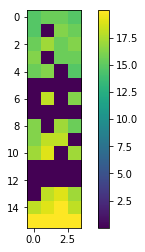

In [638]:
plt.imshow(Q_opt)
plt.colorbar()

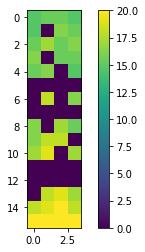

In [639]:
plt.imshow(algo.Q)
plt.colorbar()

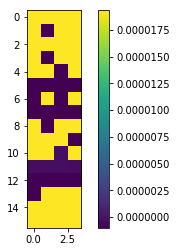

In [640]:
plt.imshow(algo.Q-Q_opt)
plt.colorbar()

In [473]:
reward.shape

(14000, 20)

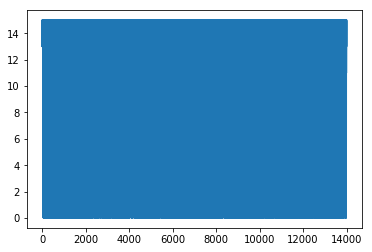

In [472]:
plt.plot(np.sum(reward, axis=1))

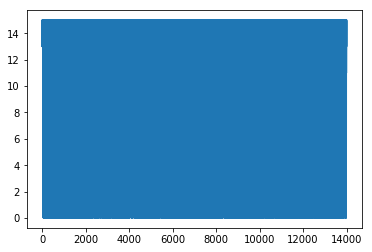

In [471]:
from matplotlib import pyplot as plt


plt.plot(np.convolve(np.sum(reward, axis=1), np.ones(1)/1.))

# Exercise 4: SARSA

SARSA is similar to Q-learning, but it is an *on-policy* algorithm: it follows a (stochastic) policy $\pi_Q$ and updates its estimate towards the value of this policy. One possible choice is:

$$
\pi_Q(a|s) = \frac{ \exp(\tau^{-1}Q(s,a))  }{\sum_{a'}\exp(\tau^{-1}Q(s,a')) }
$$
where $\tau$ is a "temperature" parameter: when $\tau$ approaches 0, $\pi_Q(a|s)$ approaches the greedy (deterministic) policy $a \in \arg\max_{a'}Q(s,a')$.

At each time $t$, SARSA keeps an estimate $\hat{Q}_t$ of the true Q function and uses $\pi_{\hat{Q}_t}(a|s)$ to choose the action $a_t$. If $\tau \to 0$ with a proper rate as $t \to \infty$, $\hat{Q}_t$ converges to $Q$ and $\pi_{\hat{Q}_t}(a|s)$ converges to the optimal policy $\pi^*$. 

The SARSA update at time $t$ is done as follows:

1. In state $s_t$, take action $a_t \sim \pi_{\hat{Q}_t}(a|s_t)$ ;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Sample the next action $a_{t+1} \sim \pi_{\hat{Q}_t}(a|s_{t+1})$;
4. Compute $\delta_t = r_t + \gamma \hat{Q}_t(s_{t+1}, a_{t+1}) - \hat{Q}_t(s_t, a_t)$
5. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$

In [0]:
#-------------------------------
# SARSA implementation
# ------------------------------

class Sarsa:
    """
    Implements SARSA algorithm.
    """
    def __init__(self, env, gamma, learning_rate=None, tau=1.0): # Again, those are suggestions, you can add more arguments
        pass
    def act():
        pass
    def optimize():
        pass


In [0]:
# ---------------------------
# Convergence of SARSA
# ---------------------------

# Create SARSA object
sarsa = Sarsa(env, gamma=env.gamma)

# Again, you can use Q_opt and pi_opt from value_iteration to check sarsa's convergence. 

How those two algorithms behave ? 
Do both of them find the optimal policy ?

## Trying other algorithms


### Policy iteration
Policy iteration is another algorithm to find an optimal policy when the MDP is known:

$$
\pi_{n} \gets \mathrm{greedy}(V_{\pi_{n-1}}) \\
V_{\pi_n} \gets \mbox{policy-evaluation}(\pi_n)
$$
For any arbitrary $\pi_0$, $\pi_n$ converges to $\pi^*$.

Implement policy iteration and compare it to value iteration.


### Stochastic algorithms for policy evaluation

Given a policy $\pi$, implement different stochastic algorithms to estimate its value $V_\pi$.

#### Monte Carlo estimation

$$
V_\pi(s) = E\left[ \sum_{t=0}^\infty \gamma^t r(S_t, A_t, S_{t+1}) | S_0 = s \right] \approx \frac{1}{N} \sum_{i=1}^N \sum_{t=0}^{T} \gamma^t r(s_t^i, a_t^i, s_{t+1}^i) 
$$


#### TD(0): 

Given a trajectory $ (x_t, x_{t+1}, r_t)_{t\geq 0} $ , the $t$-th step of TD(0) performs the following calculations:

$ \delta_t = r_t + \gamma \hat{V}_t(x_{t+1}) - \hat{V}_t(x_t)$

$ \hat{V}_{t+1}(x) = \hat{V}_t(x) + \alpha_t(x)\delta_t\mathbb{1}\{x=x_t\}  $ 

where $\alpha_t(x_t)$ is the step size and $\delta_t$ is called *temporal difference*.

#### TD($\lambda$):

Given a trajectory $ (x_t, x_{t+1}, r_t)_{t\geq 0} $, the $t$-th step of TD($\lambda$) performs the following calculations:

$ \delta_t = r_t + \gamma \hat{V}_t(x_{t+1}) - \hat{V}_t(x_t)$

$ z_{t+1}(x) = \mathbb{1}\{x=x_t\} + \gamma \lambda z_t(x)  $ 

$ \hat{V}_{t+1}(x) = \hat{V}_t(x) + \alpha_t(x)\delta_t z_{t+1}(x)  $ 

$ z_0(x) = 0 $

for all states $x$.